# Exploration of the Philippine Energy Demand (2022-2024) 

In [53]:
import os
import calendar

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from scipy.stats import ks_2samp

In [2]:
base_path = "../data/RTD Regional Summaries_2025-01-01 0000-2025-02-28 2300"

In [3]:
databricks_df = pd.read_csv(os.path.join(base_path, "rtd_combined.csv"))
databricks_df.head()

,run_time,mkt_type,time_interval,region_name,commodity_type,mkt_reqt,load_bid,load_curtailed,losses,generation,...,parameter_type,status,resource_type,marginal_price,hvdc_name,congestion_flag,flow_from,flow_to,overload_mw,partition_date
0,2022-07-17T00:15:00.000Z,RTD,2022-07-17T00:20:00.000Z,CMIN,10AGUS4_U03,NaN,NaN,0.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2022-07-17
1,2022-07-17T20:30:00.000Z,RTD,2022-07-17T20:35:00.000Z,CMIN,14SARANG_U02,NaN,NaN,0.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2022-07-17
2,2022-07-17T13:05:00.000Z,RTD,2022-07-17T13:10:00.000Z,CMIN,10AGUS6_U01,NaN,NaN,0.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2022-07-17
3,2022-07-17T15:30:00.000Z,RTD,2022-07-17T15:35:00.000Z,CMIN,10AGUS4_U03,NaN,NaN,0.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2022-07-17
4,2022-07-17T02:50:00.000Z,RTD,2022-07-17T02:55:00.000Z,CLUZ,03QPPL_G01,NaN,NaN,7227.4,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2022-07-17


In [24]:
cols_to_keep = ["run_time", "time_interval", "region_name", "mkt_reqt"]
cols_to_group = ["run_time", "time_interval"]

databricks_df[["run_time", "time_interval"]] = databricks_df[["run_time", "time_interval"]].apply(pd.to_datetime)

mask = (databricks_df["run_time"]>="2022-01-01") & (databricks_df["time_interval"]<"2025-01-01") & (databricks_df["commodity_type"]=="En")
reduced_df = databricks_df[mask].sort_values("run_time")[cols_to_keep].groupby(cols_to_group, as_index=False)["mkt_reqt"].sum()

In [25]:
print(reduced_df.shape)

reduced_df.head()

(314885, 3)


,run_time,time_interval,mkt_reqt
0,2022-01-01 00:00:00+00:00,2022-01-01 00:05:00+00:00,8209.66
1,2022-01-01 00:05:00+00:00,2022-01-01 00:10:00+00:00,8241.92
2,2022-01-01 00:10:00+00:00,2022-01-01 00:15:00+00:00,8171.55
3,2022-01-01 00:15:00+00:00,2022-01-01 00:20:00+00:00,8124.73
4,2022-01-01 00:20:00+00:00,2022-01-01 00:25:00+00:00,8129.98


In [26]:
reduced_df["year"] = reduced_df["run_time"].dt.year
reduced_df["month"] = reduced_df["run_time"].dt.month + (reduced_df["run_time"].dt.day - 1) / 31

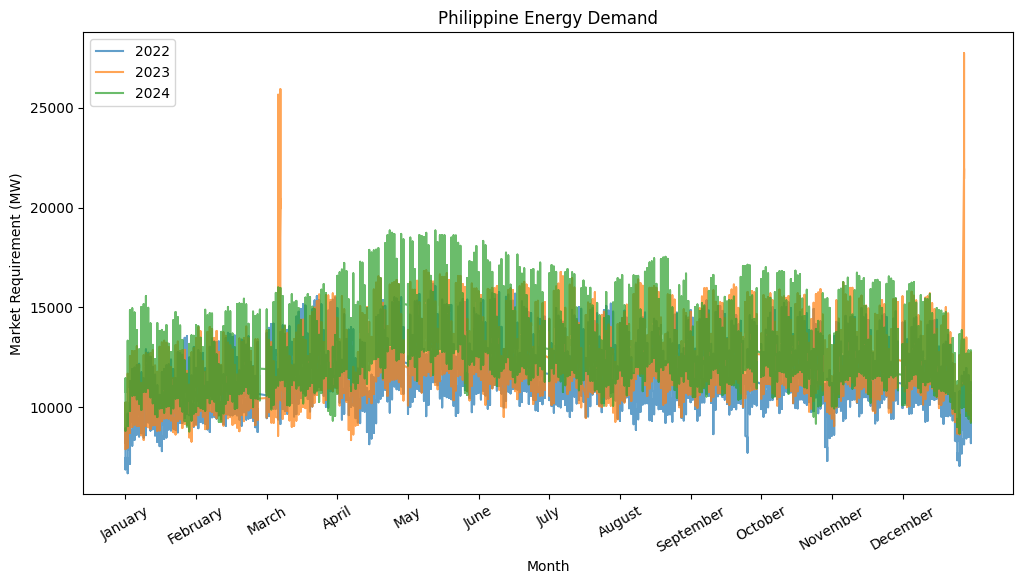

In [39]:
plt.figure(figsize=(12, 6))

for year in reduced_df["year"].unique():
    subset = reduced_df[reduced_df["year"] == year]
    plt.plot(subset["month"], subset["mkt_reqt"], label=year, alpha=0.7)

plt.xlabel("Month")
plt.ylabel("Market Requirement (MW)")
plt.title("Philippine Energy Demand")
plt.xticks(range(1, 13), calendar.month_name[1:13], rotation=30)  
plt.legend()
plt.show()

## Data Drift

In [44]:
demand_2022 = reduced_df[reduced_df["year"]==2022]["mkt_reqt"]
demand_2023 = reduced_df[reduced_df["year"]==2023]["mkt_reqt"]
demand_2024 = reduced_df[reduced_df["year"]==2024]["mkt_reqt"]

### Kolmogorov-Smirnov (KS) Test

KS Statistic: 0.13387841408986234
P-value: 0.0
Significant Data Drift Detected (Reject Null Hypothesis)


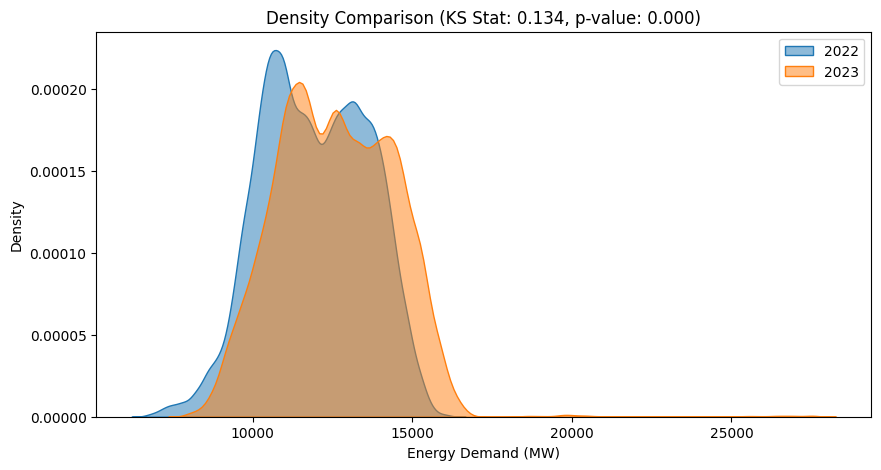

In [61]:
ks_stat, p_value = ks_2samp(demand_2022, demand_2023)

print(f"KS Statistic: {ks_stat}")
print(f"P-value: {p_value}")

if p_value < 0.05:
    print("Significant Data Drift Detected (Reject Null Hypothesis)")
else:
    print("No Significant Drift (Fail to Reject Null Hypothesis)")

plt.figure(figsize=(10,5))

sns.kdeplot(demand_2022, label="2022", fill=True, alpha=0.5)
sns.kdeplot(demand_2023, label="2023", fill=True, alpha=0.5)

plt.title(f"Density Comparison (KS Stat: {ks_stat:.3f}, p-value: {p_value:.3f})")
plt.xlabel("Energy Demand (MW)")
plt.ylabel("Density")
plt.legend()
plt.show()

KS Statistic: 0.30463679128952215
P-value: 0.0
Significant Data Drift Detected (Reject Null Hypothesis)


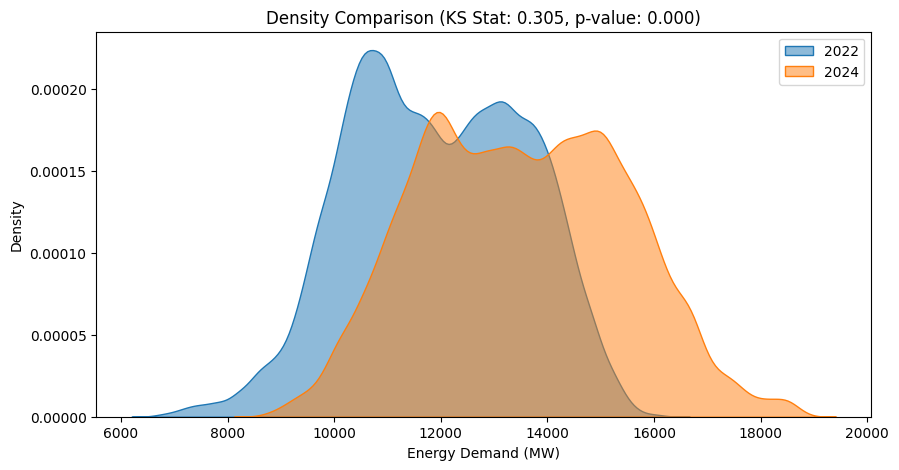

In [62]:
ks_stat, p_value = ks_2samp(demand_2022, demand_2024)

print(f"KS Statistic: {ks_stat}")
print(f"P-value: {p_value}")

if p_value < 0.05:
    print("Significant Data Drift Detected (Reject Null Hypothesis)")
else:
    print("No Significant Drift (Fail to Reject Null Hypothesis)")

plt.figure(figsize=(10,5))

sns.kdeplot(demand_2022, label="2022", fill=True, alpha=0.5)
sns.kdeplot(demand_2024, label="2024", fill=True, alpha=0.5)

plt.title(f"Density Comparison (KS Stat: {ks_stat:.3f}, p-value: {p_value:.3f})")
plt.xlabel("Energy Demand (MW)")
plt.ylabel("Density")
plt.legend()
plt.show()

KS Statistic: 0.1736424047002949
P-value: 0.0
Significant Data Drift Detected (Reject Null Hypothesis)


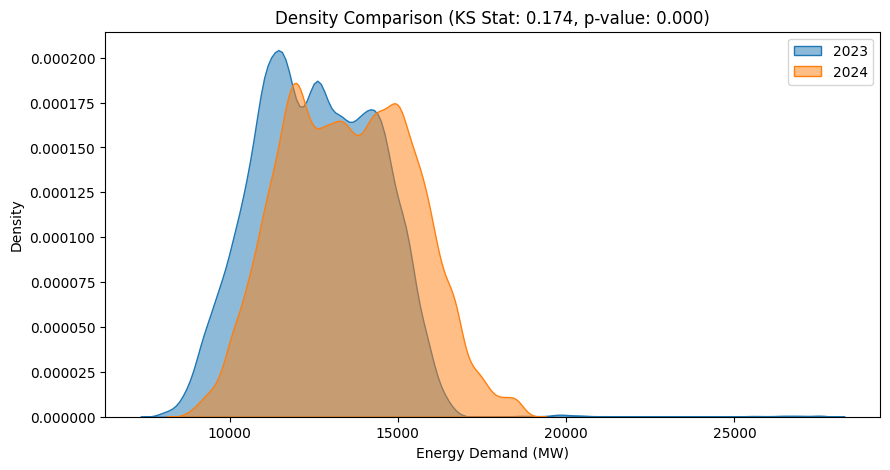

In [63]:
ks_stat, p_value = ks_2samp(demand_2023, demand_2024)

print(f"KS Statistic: {ks_stat}")
print(f"P-value: {p_value}")

if p_value < 0.05:
    print("Significant Data Drift Detected (Reject Null Hypothesis)")
else:
    print("No Significant Drift (Fail to Reject Null Hypothesis)")

plt.figure(figsize=(10,5))

sns.kdeplot(demand_2023, label="2023", fill=True, alpha=0.5)
sns.kdeplot(demand_2024, label="2024", fill=True, alpha=0.5)

plt.title(f"Density Comparison (KS Stat: {ks_stat:.3f}, p-value: {p_value:.3f})")
plt.xlabel("Energy Demand (MW)")
plt.ylabel("Density")
plt.legend()
plt.show()

### Population Stability Index (PSI)

In [48]:
def calculate_psi(expected, actual, bins=10):
    """
    Compute Population Stability Index (PSI)
    """
    breakpoints = np.linspace(min(expected), max(expected), bins + 1)

    expected_hist, _ = np.histogram(expected, bins=breakpoints)
    actual_hist, _ = np.histogram(actual, bins=breakpoints)

    expected_perc = expected_hist / sum(expected_hist)
    actual_perc = actual_hist / sum(actual_hist)

    expected_perc = np.where(expected_perc == 0, 0.0001, expected_perc)
    actual_perc = np.where(actual_perc == 0, 0.0001, actual_perc)

    psi_values = (expected_perc - actual_perc) * np.log(expected_perc / actual_perc)
    psi = np.sum(psi_values)

    return psi


In [49]:
psi_value = calculate_psi(demand_2022, demand_2023)

print(f"PSI Value: {psi_value}")

if psi_value < 0.1:
    print("No significant drift detected.")
elif psi_value < 0.25:
    print("Moderate drift detected.")
else:
    print("Significant drift detected.")

PSI Value: 0.2317842724341057
Moderate drift detected.


In [50]:
psi_value = calculate_psi(demand_2022, demand_2024)

print(f"PSI Value: {psi_value}")

if psi_value < 0.1:
    print("No significant drift detected.")
elif psi_value < 0.25:
    print("Moderate drift detected.")
else:
    print("Significant drift detected.")

PSI Value: 0.8392599674031611
Significant drift detected.


In [51]:
psi_value = calculate_psi(demand_2023, demand_2024)

print(f"PSI Value: {psi_value}")

if psi_value < 0.1:
    print("No significant drift detected.")
elif psi_value < 0.25:
    print("Moderate drift detected.")
else:
    print("Significant drift detected.")

PSI Value: 0.3362997144813991
Significant drift detected.


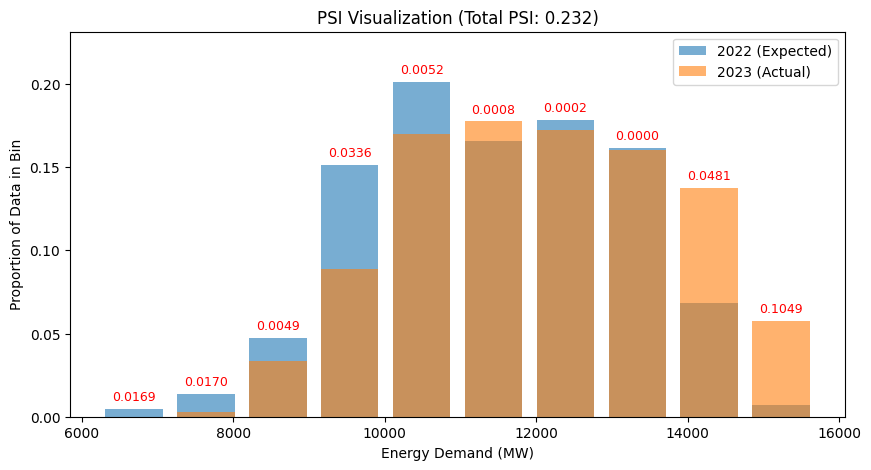

PSI Value: 0.2317842724341057


In [70]:
def plot_psi(expected, actual, bins=10):
    """
    Compute and visualize the Population Stability Index (PSI)
    """
    breakpoints = np.linspace(min(expected), max(expected), bins + 1)

    expected_hist, _ = np.histogram(expected, bins=breakpoints)
    actual_hist, _ = np.histogram(actual, bins=breakpoints)

    expected_perc = expected_hist / sum(expected_hist)
    actual_perc = actual_hist / sum(actual_hist)

    expected_perc = np.where(expected_perc == 0, 0.0001, expected_perc)
    actual_perc = np.where(actual_perc == 0, 0.0001, actual_perc)

    psi_values = (expected_perc - actual_perc) * np.log(expected_perc / actual_perc)
    psi = np.sum(psi_values)

    plt.figure(figsize=(10,5))
    bar_width = (breakpoints[1] - breakpoints[0]) * 0.8  # Adjust bar width

    plt.bar(breakpoints[:-1], expected_perc, width=bar_width, alpha=0.6, label="2022 (Expected)")
    plt.bar(breakpoints[:-1], actual_perc, width=bar_width, alpha=0.6, label="2023 (Actual)")

    for i in range(len(breakpoints) - 1):
        plt.text(breakpoints[i], max(expected_perc[i], actual_perc[i]) + 0.005,
                 f"{psi_values[i]:.4f}", ha='center', fontsize=9, color="red")
        
    max_prop = max(max(expected_perc), max(actual_perc))  # Find the highest proportion value

    plt.title(f"PSI Visualization (Total PSI: {psi:.3f})")
    plt.xlabel("Energy Demand (MW)")
    plt.ylabel("Proportion of Data in Bin")
    plt.ylim(0, max_prop + 0.03)
    plt.legend()
    plt.show()

    return psi

# Run and visualize PSI
psi_value = plot_psi(demand_2022, demand_2023)
print(f"PSI Value: {psi_value}")


### Concept Drift

PLACEHOLDER ONLY!!! NOT REAL DATA YET

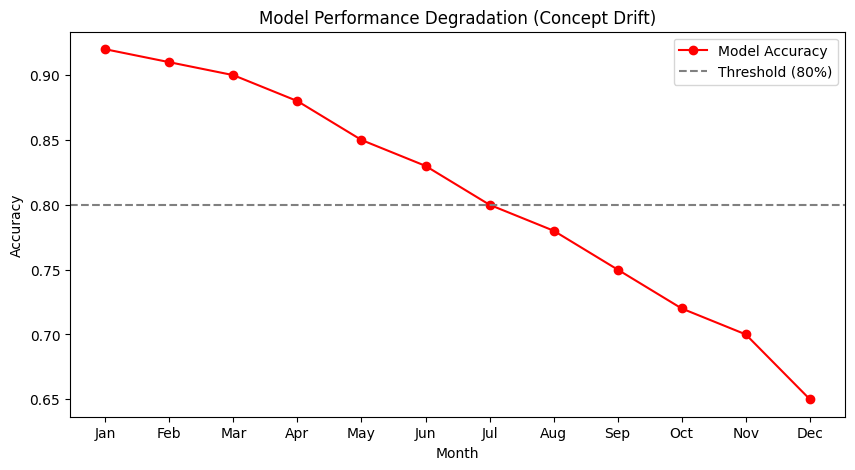

In [ ]:
months = ["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"]
accuracy = [0.92, 0.91, 0.90, 0.88, 0.85, 0.83, 0.80, 0.78, 0.75, 0.72, 0.70, 0.65]  # Simulating drift

plt.figure(figsize=(10,5))
plt.plot(months, accuracy, marker="o", linestyle="-", color="red", label="Model Accuracy")
plt.axhline(y=0.8, color="gray", linestyle="--", label="Threshold (80%)")
plt.xlabel("Month")
plt.ylabel("Accuracy")
plt.title("Model Performance Degradation (Concept Drift)")
plt.legend()
plt.show()
